In [34]:
import pandas as pd
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
import axelrod as axl
import axelrod.interaction_utils as iu

import testzd as zd

C, D = axl.Action.C, axl.Action.D

# Investigate whether or not a strategy is zero determinant.

In [1], given a match between 2 memory one strategies the concept of Zero Determinant strategies is introduced. This result showed that a player $p\in\mathbb{R}^4$ against a player $q\in\mathbb{R}^4$ could force a linear relationship between the scores.

Assuming the following:

- The utilities for player $p$: $S_x = (R, S, T, P)$ and for player $q$: $S_y = (R, T, S, P)$.
- The normalised long run score for player $p$: $s_x$ and for player $q$: $s_y$.
- Given $p=(p_1, p_2, p_3, p_4)$ a transformed (but equivalent) vector: $\tilde p=(p_1 - 1, p_2 - 1, p_3, p_4)$, similarly: $\tilde q=(1 - q_1, 1 - q_2, q_3, q_4)$

The main result of [1] is that:

if $\tilde p = \alpha S_x + \beta S_y + \gamma 1$ **or** if $\tilde q = \alpha S_x + \beta S_y + \gamma 1$ then:

$$
\alpha s_x + \beta s_y + \gamma 1 = 0
$$

where $\alpha, \beta, \gamma \in \mathbb{R}$

The question arises:

**Given a strategy $p$, is it a zero determinant strategy?**

This is equivalent to finding $\alpha, \beta, \gamma \in \mathbb{R}$ such that $\tilde p = \alpha S_x + \beta S_y + \gamma 1$.

Recall that $\tilde p, S_x, S_y, 1\in\mathbb{R}^{4\times 1}$ so this corresponds to a linear system of 4 equations on three variables.

$$\tilde p=Mx$$

Where:

$$
M = \begin{pmatrix}S_x, S_y, 1\end{pmatrix}\in\mathbb{R}^{4\times 3}
$$

As an example consider the `extort-2` strategy defined in [2]. This is given by:

$$p=(8/9, 1/2, 1/3, 0)$$

it is defined to ensure:

$$
\begin{aligned}
\alpha s_x - P &= 2(s_y - P)\\
\alpha s_x - 2s_y + P&=0\\
\end{aligned}
$$

Let us solve $Mx=\tilde p$

In [35]:
R, S, T, P = sym.S(3), sym.S(0), sym.S(5), sym.S(1)

tilde_p = sym.Matrix([sym.S(8) / 9 - 1, sym.S(1) / 2 - 1, sym.S(1) / 3, sym.S(0)])
M = sym.Matrix([[R, R, 1], 
                [S, T, 1],
                [T, S, 1], 
                [P, P, 1]])

In [36]:
system = (M, tilde_p)
symbols = sym.symbols("alpha, beta, gamma")
sym.linsolve(system, symbols)

{(1/18, -1/9, 1/18)}

This gives $\alpha = 1 / 18$, $\beta = -1/9$ and $\gamma = 1 / 18$ which ensures:

$$
1/18 s_x -1/9 s_y + 1/18 = 0
$$

multiplying this by 18 gives:


$$
s_x -2 s_y + 1 = 0
$$

which is the relationship described above.

Note that in practice, a vector $p$ might not be defined exactly: indeed it could be measured from observation. Thus: $p\notin\mathbb{Q}^{4\times 1}$ but $p\in\mathbb{R}^{4\times 1}$. As such that linear equations may no longer have exact solutions and/or indeed have no solutions at all as $M$ is not a square matrix.

A practical approach to checking if a strategy is ZD or not makes use of the continuity of the determinant of a matrix. As the calculation of a matrix is a linear combination of its elements, a matrix with determinant "almost" zero is close to a matrix that has zero determinant.

## $\epsilon$-ZD strategies

We define:

$$\bar M ^{(i)} = M_{(i; i)}$$

The matrix $\bar M ^{(i)}\in\mathbb{R}^{3\times 3}$ is the matrix $M$ with the $i$th row removed.

Similarly:

$$\bar p^{(i)} = \tilde p_{(i)}$$

The vector $\bar p^{(i)}\in\mathbb{R}^{3\times 1}$ is the vector $\tilde p$ with the $i$th element removed.

Solving 

$$\bar M ^{(i)} x^{(i)} = \bar p^{(i)}$$ 

gives $\bar x^{(i)}$ and if $\min _{1\leq i\leq 4}|M_i\bar x^{(i)} - \tilde p_i| < \epsilon$ for some $\epsilon > 0$ then $p$ is $\epsilon$-ZD.

Thus if $\epsilon$-ZD are strategies for which values of $\alpha, \beta, \gamma$ can be found that make the strategy "close" to being a ZD strategy.

Let us confirm that `Extort-2` is $\epsilon$-ZD with $\epsilon=10 ^ {-7}$:

In [55]:
p = np.array([8 / 9, 1 / 2, 1 / 3, 0])
zd.is_epsilon_ZD(p, epsilon=10 ** -7)

True

Note that the following vector is not:

$$p = (8 / 9, 1, 1 / 3, 0)$$

In [59]:
zd.is_epsilon_ZD(np.array([8 / 9, 1, 1 / 3, 0]), epsilon=10 ** -7)

False

Furthermore we can simulate the play of strategies and measure the probabilities:

In [60]:
players = axl.ZDExtort2(), axl.Alternator()
match = axl.Match(players, turns=10 ** 6)
interactions = match.play()

In [61]:
p = []
state_counter = iu.compute_normalised_state_to_action_distribution(interactions)[0]
for state in ((C, C), (C, D), (D, C), (D, D)):
    p.append(state_counter[(state, C)])
p = np.array(p)
p

array([0.88918582, 0.49905945, 0.33246002, 0.        ])

We see that that measure of $p$ is not $\epsilon$-ZD for $\epsilon=10 ^ {-7}$:

In [64]:
zd.is_epsilon_ZD(p, epsilon=10 ** -7)

False

However it is for $\epsilon=10 ^ {-2}$:

In [65]:
zd.is_epsilon_ZD(p, epsilon=10 ** -2)

True

In fact the lowest $\epsilon$ for which $p$ is $\epsilon$-ZD is $\epsilon=0.0016$:

In [67]:
zd.find_lowest_epsilon(p)

0.0016000000000000005

Let us consider a few other strategies/tournament and evaluate their performance:

## Empirical observation

Let us consider the latest tournament of the Axelrod project: awaiting data collection.

## Evaluate the Press and Dyson tournament

Firslty let us look at the tournament of [2].

In [71]:
df = pd.read_csv("./data/stewart_plotkin_tournament/summary/std/main.csv")

In [73]:
def analyse_tournament_behaviour(df, epsilons):
    """
    Obtain a pandas data from that tests the behaviour of a tournament for a
    range of epsilons.
    """
    columns = ["CC_to_C_rate", "CD_to_C_rate", "DC_to_C_rate", "DD_to_C_rate"]

    counts = []

    data = {"epsilon":epsilons,
            "counts":[],
            "five_percent_quantile_ranks":[],
            "min_ranks":[],
            "median_ranks":[],
            "ninetyfive_percent_quantile_ranks":[],
            "max_ranks":[],
            "min_score_per_turn":[],
            "five_percent_quantile_score_per_turn":[],
            "mean_score_per_turn":[],
            "ninetyfive_percent_quantile_score_per_turn":[],
            "max_score_per_turn":[],
            "min_number_of_wins":[],
            "five_percent_quantile_number_of_wins":[],
            "median_number_of_wins":[],
            "ninetyfive_percent_quantile_number_of_wins":[],
            "max_number_of_wins":[],
            "min_cooperation_rate":[],
            "five_percent_quantile_cooperation_rate":[],
            "mean_cooperation_rate":[],
            "ninetyfive_percent_quantile_cooperation_rate":[],
            "max_cooperation_rate":[]}

    for epsilon in epsilons:
        played_ZD = []

        for _, row in df.iterrows():
            p = np.array(row[columns])
            played_ZD.append(zd.is_epsilon_ZD(p, epsilon=epsilon))

        data["counts"].append(sum(played_ZD))

        zd_df = df[played_ZD]

        data["min_ranks"].append(zd_df["Rank"].min())
        data["five_percent_quantile_ranks"].append(zd_df["Rank"].quantile(q=0.05))
        data["median_ranks"].append(zd_df["Rank"].median())
        data["ninetyfive_percent_quantile_ranks"].append(zd_df["Rank"].quantile(q=0.95))
        data["max_ranks"].append(zd_df["Rank"].max())

        data["min_score_per_turn"].append(zd_df["Median_score"].min())
        data["five_percent_quantile_score_per_turn"].append(zd_df["Median_score"].quantile(q=0.05))
        data["mean_score_per_turn"].append(zd_df["Median_score"].mean())
        data["ninetyfive_percent_quantile_score_per_turn"].append(zd_df["Median_score"].quantile(q=0.95))
        data["max_score_per_turn"].append(zd_df["Median_score"].max())

        data["min_number_of_wins"].append(zd_df["Wins"].min())
        data["five_percent_quantile_number_of_wins"].append(zd_df["Wins"].quantile(q=0.05))
        data["median_number_of_wins"].append(zd_df["Wins"].median())
        data["ninetyfive_percent_quantile_number_of_wins"].append(zd_df["Wins"].quantile(q=0.95))
        data["max_number_of_wins"].append(zd_df["Wins"].max())

        data["min_cooperation_rate"].append(zd_df["Cooperation_rating"].min())
        data["five_percent_quantile_cooperation_rate"].append(zd_df["Cooperation_rating"].quantile(q=0.05))
        data["mean_cooperation_rate"].append(zd_df["Cooperation_rating"].mean())
        data["ninetyfive_percent_quantile_cooperation_rate"].append(zd_df["Cooperation_rating"].quantile(q=0.95))
        data["max_cooperation_rate"].append(zd_df["Cooperation_rating"].max())
    return pd.DataFrame(data)

In [75]:
epsilons = 10 ** np.linspace(0, -4, 100)

In [76]:
std_df = analyse_tournament_behaviour(df, epsilons=epsilons)

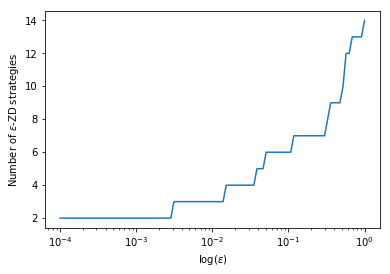

In [78]:
fig = plt.figure()
ax = plt.gca()

ax.plot(std_df["epsilon"], std_df["counts"]);
ax.set_xscale('log')
    
plt.xlabel("$\log(\epsilon)$")
plt.ylabel(f"Number of $\epsilon$-ZD strategies")
plt.show();

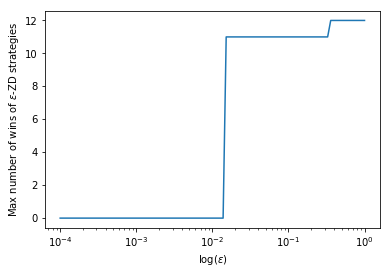

In [84]:
fig = plt.figure()
ax = plt.gca()

ax.plot(std_df["epsilon"], std_df["max_number_of_wins"]);
ax.set_xscale('log')
    
plt.xlabel("$\log(\epsilon)$")
plt.ylabel(f"Max number of wins of $\epsilon$-ZD strategies")
plt.show();

## References

[1] Press, William H., and Freeman J. Dyson. "Iterated Prisoner’s Dilemma contains strategies that dominate any evolutionary opponent." Proceedings of the National Academy of Sciences 109.26 (2012): 10409-10413

[2] Stewart, Alexander J., and Joshua B. Plotkin. "Extortion and cooperation in the Prisoner’s Dilemma." Proceedings of the National Academy of Sciences 109.26 (2012): 10134-10135.

In [13]:
df.head()

,Interaction index,Player index,Opponent index,Repetition,Player name,Opponent name,Actions,Score,Score difference,Turns,...,DD count,CC to C count,CC to D count,CD to C count,CD to D count,DC to C count,DC to D count,DD to C count,DD to D count,Good partner
0,0,0,1,0,Cooperator,Defector,CCCCCCCCCCCCCCCCCCCCDCCCCCCCDCCCCCCCCCCDCCDCCC...,409,-9000,2000,...,92,88,6,1720,86,6,1,86,6,1
1,0,1,0,0,Defector,Cooperator,DDDDDDDDDDDDDDDDDDDDCDDDDDDDDDDDDDDDDDDDDDDCDD...,9409,9000,2000,...,92,7,87,0,7,89,1717,5,87,0
2,1,0,1,1,Cooperator,Defector,CCCCCCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCC...,399,-9055,2000,...,83,99,3,1736,76,2,0,77,6,1
3,1,1,0,1,Defector,Cooperator,DDDCDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...,9454,9055,2000,...,83,5,97,1,1,90,1722,8,75,0
4,2,0,1,2,Cooperator,Defector,CCCDCCCCCCCCCCCCDCDCCCCCCCCCCCCCCDCCCCCCCCCCCC...,406,-8995,2000,...,94,87,2,1712,95,9,0,88,6,1


In [11]:
import sympy as sym
sym.S(7) / 60 + sym.S(1) / 15

11/60